In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV


#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
# warnings.filterwarnings("ignore", category=np.DeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
    dropfeat = [i.replace('\n','') for i in d.readlines()]

In [82]:
# with open('test_ind.pickle', 'rb') as handle:
#     test_ind = pickle.load(handle)

# with open('train_ind.pickle', 'rb') as handle:
#     train_ind = pickle.load(handle)

with open('big_test_ind.pickle', 'rb') as handle:
    test_ind = pickle.load(handle)

with open('big_train_ind.pickle', 'rb') as handle:
    train_ind = pickle.load(handle)

comb_ind = np.hstack([train_ind,test_ind])
train_ind = comb_ind[comb_ind<170]
test_ind = comb_ind[comb_ind>170]    
# train_ind = list(map(float,train_ind))
# test_ind = list(map(float,test_ind))
# train_ind, test_ind = train_test_split(train_ind+test_ind,test_size=0.1, random_state=42)
total_data = len(train_ind)+len(test_ind)
print(len(train_ind)/total_data,len(test_ind)/total_data)    


0.8448844884488449 0.1551155115511551


In [83]:
87


87

In [84]:
train = []
test = []



recover_train = []
recover_test = []

traincnt = 0
testcnt = 0
# TZP: 1e-5
# DZP: 1e-5
# mb: 1e-3
for i in sorted(glob('ANO-RCC-MB')):
    print(i)
    for j in glob(os.path.join(i,'ozone_*')):
        for k in train_ind:
            if f"{k:.2f}" in j:
                traindf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                traindf = traindf[traindf['Pair_Energies'].abs()>=1e-5]
                train.append(traindf)
                recover_train.append((i,f"{k:.2f}",traincnt,len(traindf)))
                traincnt+=1
                
        for l in test_ind:
            if f"{l:.2f}" in j:
                testdf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                testdf = testdf[testdf['Pair_Energies'].abs()>=1e-5]
                test.append(testdf)                    
                recover_test.append((i,f"{l:.2f}",testcnt,len(testdf)))
                testcnt+=1

ANO-RCC-MB


In [85]:
rename = {'h$_{qq}^{0}$':'h$_{q}$',
'$(F_{q})_{0}$':'$F_{q}$',
'$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
'$(\\eta_{q})_{0}$':'$\\eta_{q}$',
'$(\\omega_{q})_{0}$':'$\\omega_{q}$',
'$(\\eta_{s})_{0}$':'$\\eta_{s}$',
'h$_{ss}^{0}$':'h$_{s}$',
'$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
'$(F_{s})_{0}$':'$F_{s}$',
'$(\\omega_{s})_{0}$':'$\\omega_{s}$',
'$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
'$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
'h$_{pp}^{0}$': '(h$_{p}$)$_{0}$',
'h$_{pp}^{1}$': '(h$_{p}$)$_{1}$',
'h$_{pp}^{2}$': '(h$_{p}$)$_{2}$',
'h$_{pp}^{3}$': '(h$_{p}$)$_{3}$',
'h$_{rr}^{0}$': '(h$_{r}$)$_{0}$',
'h$_{rr}^{1}$': '(h$_{r}$)$_{1}$',
'h$_{rr}^{2}$': '(h$_{r}$)$_{2}$',
'h$_{rr}^{3}$': '(h$_{r}$)$_{3}$',
'h$_{pq}^{0}$':'(h$_{pq}$)$_{0}$',
'h$_{pq}^{1}$':'(h$_{pq}$)$_{1}$',
'h$_{pq}^{2}$':'(h$_{pq}$)$_{2}$',
'h$_{pq}^{3}$':'(h$_{pq}$)$_{3}$',
'h$_{pr}^{0}$':'(h$_{pr}$)$_{0}$',
'h$_{pr}^{1}$':'(h$_{pr}$)$_{1}$',
'h$_{pr}^{2}$':'(h$_{pr}$)$_{2}$',
'h$_{pr}^{3}$':'(h$_{pr}$)$_{3}$',
'h$_{rs}^{0}$':'(h$_{rs}$)$_{0}$',
'h$_{rs}^{1}$':'(h$_{rs}$)$_{1}$',
'h$_{rs}^{2}$':'(h$_{rs}$)$_{2}$',
'h$_{rs}^{3}$':'(h$_{rs}$)$_{3}$',
'typ_0':'$type_0$',
'typ_1':'$type_1$',
'typ_2':'$type_2$',
'typ_3':'$type_3$'}

In [86]:
train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)

In [87]:
pd.concat([train_df,test_df])[[i for i in train_df.columns if i=='(h$_{rs}$)$_{0}$']].std()

(h$_{rs}$)$_{0}$    3.528847
dtype: float64

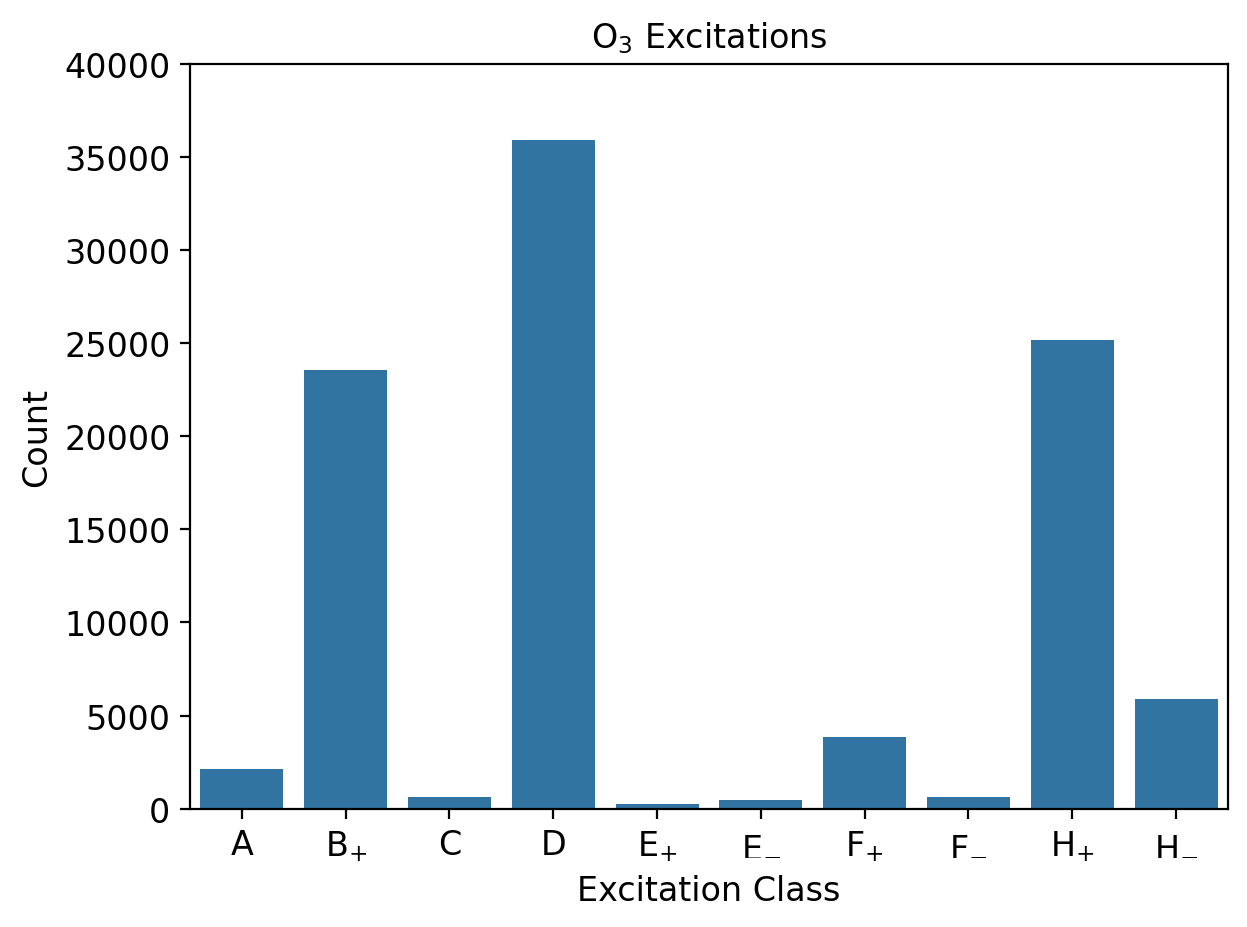

In [88]:
counttypes=pd.concat([pd.concat([train_df,test_df])[i].value_counts() for i in train_df.columns if 'typ' in i],axis=1).T.sum(axis=0).sort_index()
counttypes.index=[{1:"A", 2:"B$_{+}$", 3:"B$_{-}$", 4:"C", 5:"D", 6:"E$_{+}$", 7:"E$_{-}$", 8:"F$_{+}$", 9:"F$_{-}$", 10:"G$_{+}$", 11:"G$_{-}$", 12:"H$_{+}$", 13:"H$_{-}$"}[t] for t in counttypes.index+1]
sns.barplot(data=counttypes.reset_index(),x='index',y=0,color=sns.color_palette('Paired')[1])
plt.ylabel('Count')
plt.xlabel('Excitation Class')
plt.ylim(0,np.round(counttypes.max(), -4))
plt.title('O$_{3}$ Excitations')
plt.tight_layout()
# plt.savefig('images/excitation_barplot_MB.png',dpi=300,bbox_inches='tight')
plt.show()

In [89]:
X_train = train_df.drop(columns=['Pair_Energies']).values
X_test = test_df.drop(columns=['Pair_Energies']).values

y_train = train_df['Pair_Energies'].values
y_test = test_df['Pair_Energies'].values

In [90]:
X_train.shape

(20869, 102)

In [91]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [92]:
from xgboost import XGBRegressor

# kwargs = dict(pd.read_excel("ozone_MB_params.xlsx").values)
# model=XGBRegressor(**kwargs)
# model.fit(X_train,y_train)
# y_pred_train=model.predict(X_train)
# y_pred_test=model.predict(X_test)
# print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
# print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")

params = {'max_depth': [1, 10, 100],
          'n_estimators': [100, 500, 1000],
          'reg_lambda': [1e-6, 1e-3,1e-1],
          'reg_alpha': [1e-6, 1e-3,1e-1]}

model = XGBRegressor()
grid = GridSearchCV(estimator=model, 
                   param_grid=params,
                   scoring='r2', 
                   verbose=0,n_jobs=12).fit(X_train,y_train)


model=grid.best_estimator_
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")
# pd.DataFrame.from_dict(model.get_params(),orient='index').dropna().to_excel("ozone_MB_params.xlsx")

/home/grierjones/miniconda3/envs/DDGNN/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


R2: 0.9997,0.6964
RMSE (mEh): 0.0663,2.5523


In [93]:
try:
    os.mkdir('images')
except:
    print('./images exist')

./images exist


In [94]:
y_train.min()*1e3,y_train.max()*1e3

(np.float64(-30.302412), np.float64(13.436159))

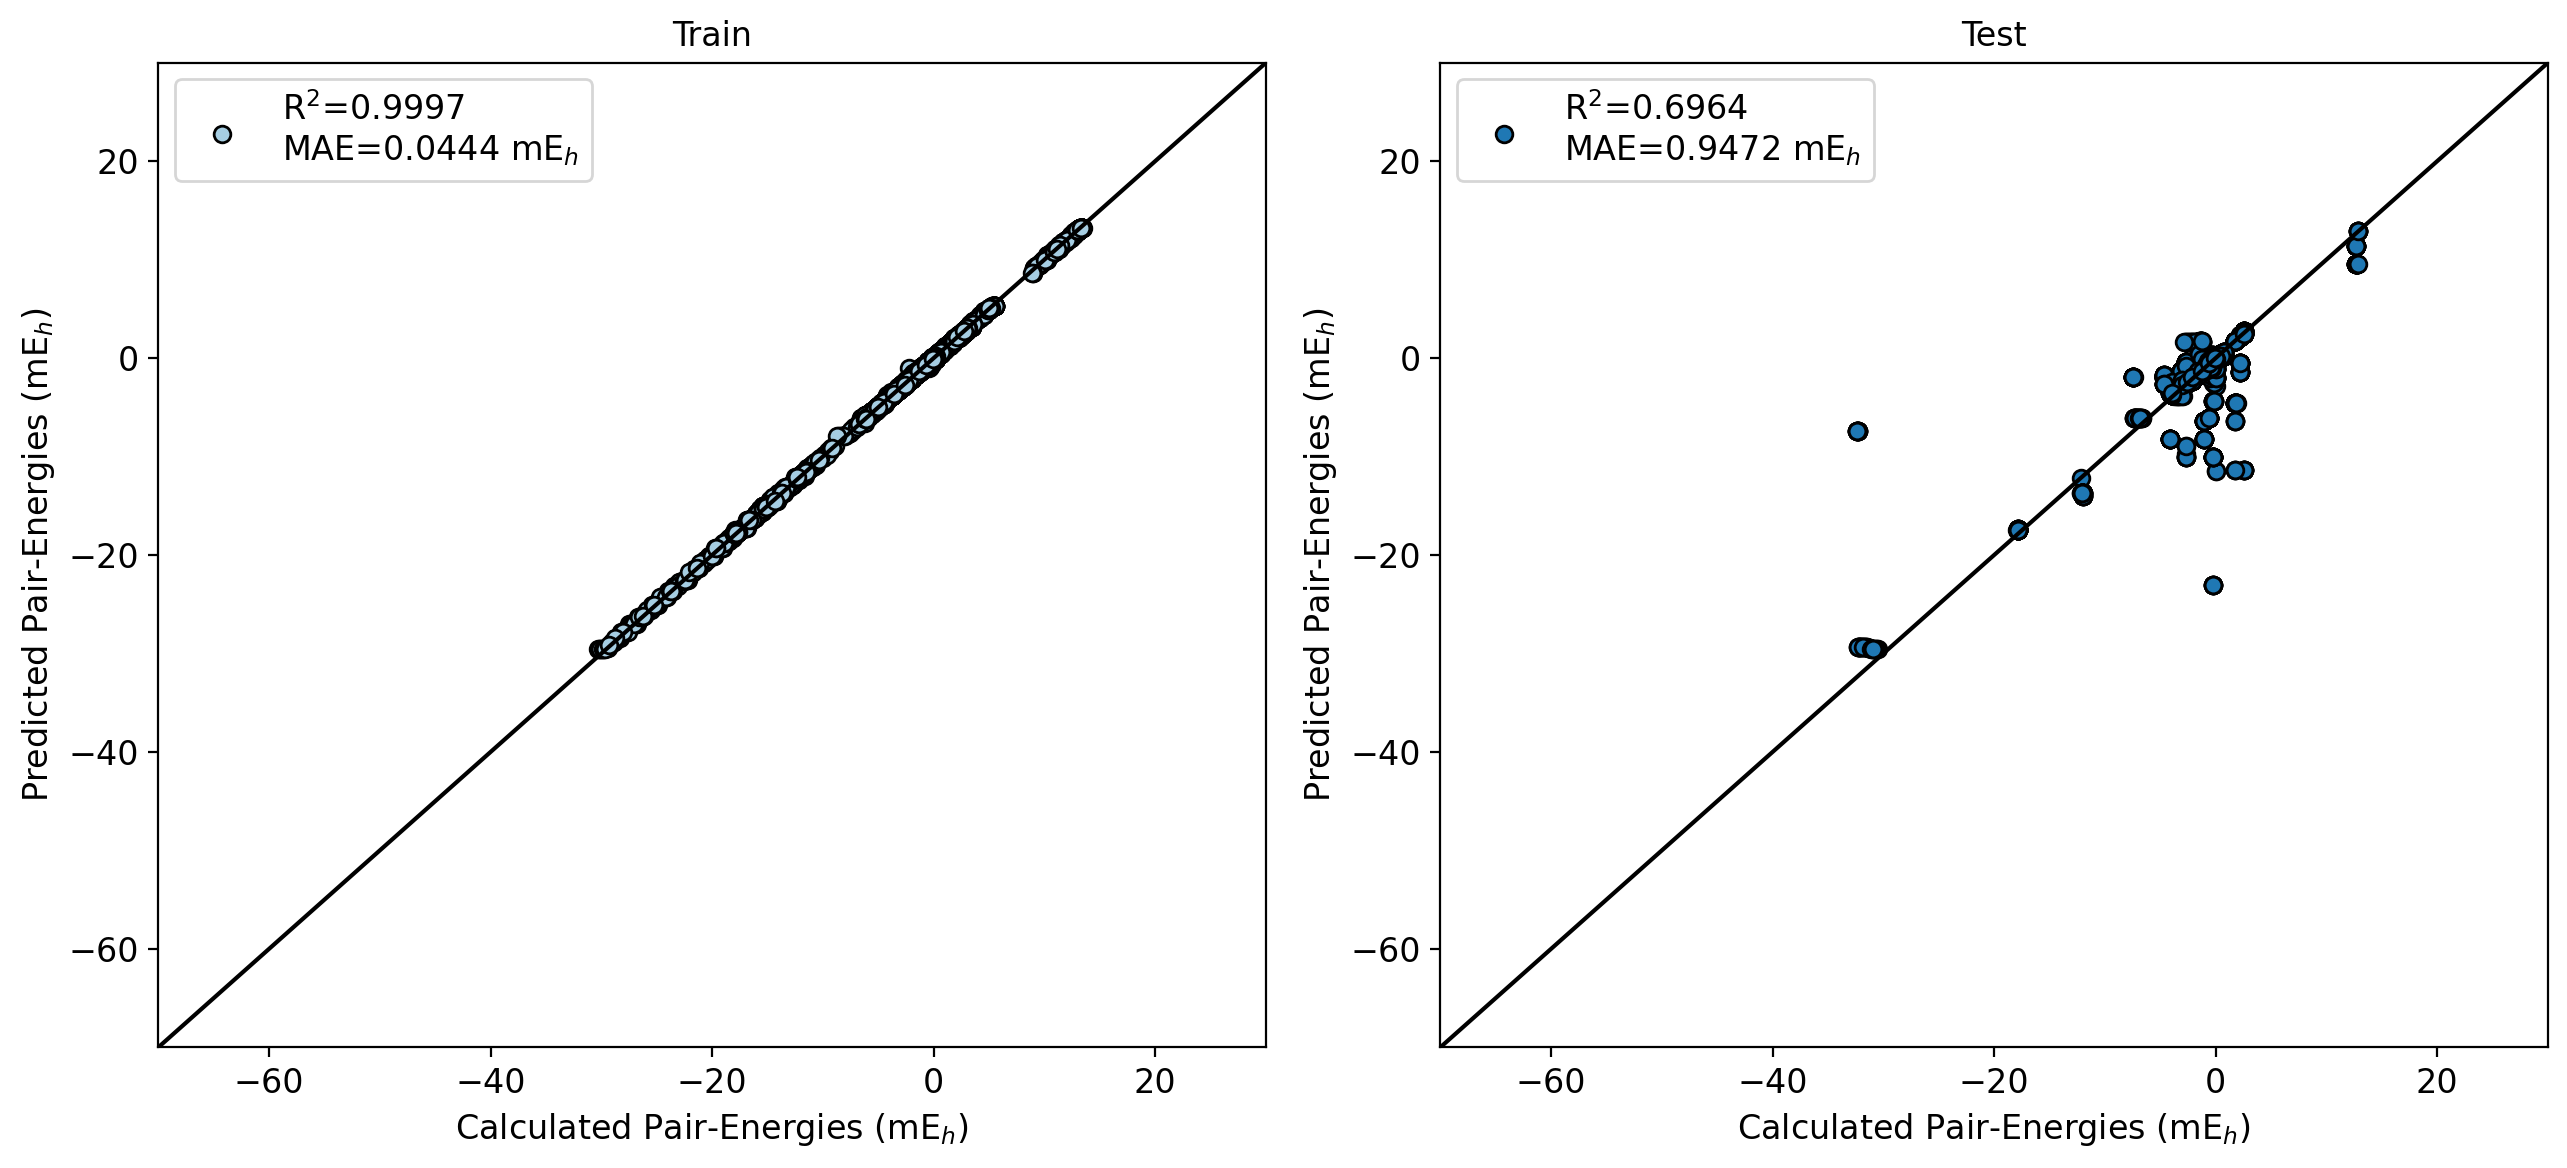

In [95]:
pal = sns.color_palette("Paired")
font=12
plt.rc('font', size=font)          # controls default text sizes
plt.rc('axes', titlesize=font)     # fontsize of the axes title
plt.rc('axes', labelsize=font)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font)    # fontsize of the tick labels
plt.rc('legend', fontsize=font)    # legend fontsize
plt.rc('figure', titlesize=font)  # fontsize of the figure title
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,6))
scale=1e-1
minL,maxL = -70, 30
ax1.set_title('Train')
ax1.scatter(1e3*y_train,1e3*y_pred_train,label="R$^{2}$="+f'{r2_score(y_train,y_pred_train):.4f}\nMAE={1e3*mean_absolute_error(y_train,y_pred_train):.4f}'+" mE$_{h}$",color=pal[0],edgecolors='k')
ax1.plot(np.arange(-100,100),np.arange(-100,100),'k-')
ax1.set_xlim(minL,maxL)
ax1.set_ylim(minL,maxL)
ax1.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax1.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax1.legend()


ax2.set_title('Test')
ax2.scatter(1e3*y_test,1e3*y_pred_test,label="R$^{2}$="+f'{r2_score(y_test,y_pred_test):.4f}\nMAE={1e3*mean_absolute_error(y_test,y_pred_test):.4f}'+" mE$_{h}$",color=pal[1],edgecolors='k')
ax2.plot(np.arange(-100,100),np.arange(-100,100),'k-')
ax2.set_xlim(minL,maxL)
ax2.set_ylim(minL,maxL)
ax2.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax2.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax2.legend()

plt.tight_layout()
# plt.savefig('images/ozone_MB_parity.png',dpi=300,bbox_inches='tight')
plt.show()

In [96]:
testcntrcvr = 0
recover_test_list = []
recover_test_E2 = []
for i,j,k,l in recover_test:
    init_test = testcntrcvr
    testcntrcvr+=l
    recover_test_list.append((i.split("_")[0],j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
    recover_test_E2.append((i.split("_")[0],j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))


traincntrcvr = 0
recover_train_list = []
recover_train_E2 = []
for i,j,k,l in recover_train:
    init_train = traincntrcvr
    traincntrcvr+=l
    recover_train_list.append((i.split("_")[0],j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
    recover_train_E2.append((i.split("_")[0],j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))

In [97]:
traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
#.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
#.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})


traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
traincorrE2['E2']=np.zeros(len(traincorrE2))

traincorrE2.index = ["_".join((u,v)) for u,v in traincorrE2[["basis set",'Angle ($^{\circ}$)']].values]

for i in traincorrE2.index:
    hn, r = i.split('_')
    energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0)
    traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
    traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
    # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values

traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']

traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)


testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
testcorrE2['E2']=np.zeros(len(testcorrE2))

testcorrE2.index = ["_".join((u,v)) for u,v in testcorrE2[["basis set",'Angle ($^{\circ}$)']].values]

for i in testcorrE2.index:
    hn, r = i.split('_')
    energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0)
    testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
    testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
    # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values

testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']

testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)

In [98]:
traincaspt2melt = traincorrE2.melt(id_vars=["basis set",'Angle ($^{\circ}$)'], value_vars=['E$_{\text{CASPT2}}^{\text{Calculated}}$','E$_{\text{CASPT2}}^{\text{Predicted}}$']).astype({'Angle ($^{\circ}$)':float,'value':float})
testcaspt2melt = testcorrE2.melt(id_vars=["basis set",'Angle ($^{\circ}$)'], value_vars=['E$_{\text{CASPT2}}^{\text{Calculated}}$','E$_{\text{CASPT2}}^{\text{Predicted}}$']).astype({'Angle ($^{\circ}$)':float,'value':float})

In [99]:
trueE2=pd.concat([traincorrE2,testcorrE2]).astype({'Angle ($^{\circ}$)':float,'E$_{\text{CASPT2}}^{\text{Calculated}}$':float})

In [100]:
mean_absolute_error(testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(19.601319336012974)

In [101]:
mean_absolute_error(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'])*1e3

np.float64(0.35650119543340075)

In [102]:
pairedcp=sns.color_palette('Paired')

In [103]:
(traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$']-traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$']).abs().sort_values()

ANO-RCC-MB_158.00    0.000002
ANO-RCC-MB_124.50    0.000004
ANO-RCC-MB_143.50    0.000007
ANO-RCC-MB_143.25    0.000007
ANO-RCC-MB_143.75    0.000012
                       ...   
ANO-RCC-MB_116.00    0.001001
ANO-RCC-MB_136.75    0.001012
ANO-RCC-MB_160.50    0.001051
ANO-RCC-MB_150.75    0.001123
ANO-RCC-MB_135.50    0.001628
Length: 256, dtype: float64

In [104]:
allcorr = pd.concat([traincorrE2,testcorrE2])

In [105]:
allcorr[['E$_{2}^{\text{Predicted}}$','E$_{2}^{\text{Calculated}}$']].describe().loc[['min','max']]

,E$_{2}^{\text{Predicted}}$,E$_{2}^{\text{Calculated}}$
min,-0.137283,-0.101326
max,-0.089342,-0.093890


In [106]:
allcorr.min()

basis set                                  ANO-RCC-MB
Angle ($^{\circ}$)                             106.00
E$_{2}^{\text{Calculated}}$                 -0.101326
E$_{2}^{\text{Predicted}}$                  -0.137283
E$_{\text{CASPT2}}^{\text{Calculated}}$   -224.464101
E$_{\text{CASSCF}}^{\text{Calculated}}$   -224.367689
E2                                                0.0
E$_{\text{CASPT2}}^{\text{Predicted}}$    -224.464072
dtype: object

0.9597666630388709
-224.46410067 -224.36172427985898
-224.5 -224.1984


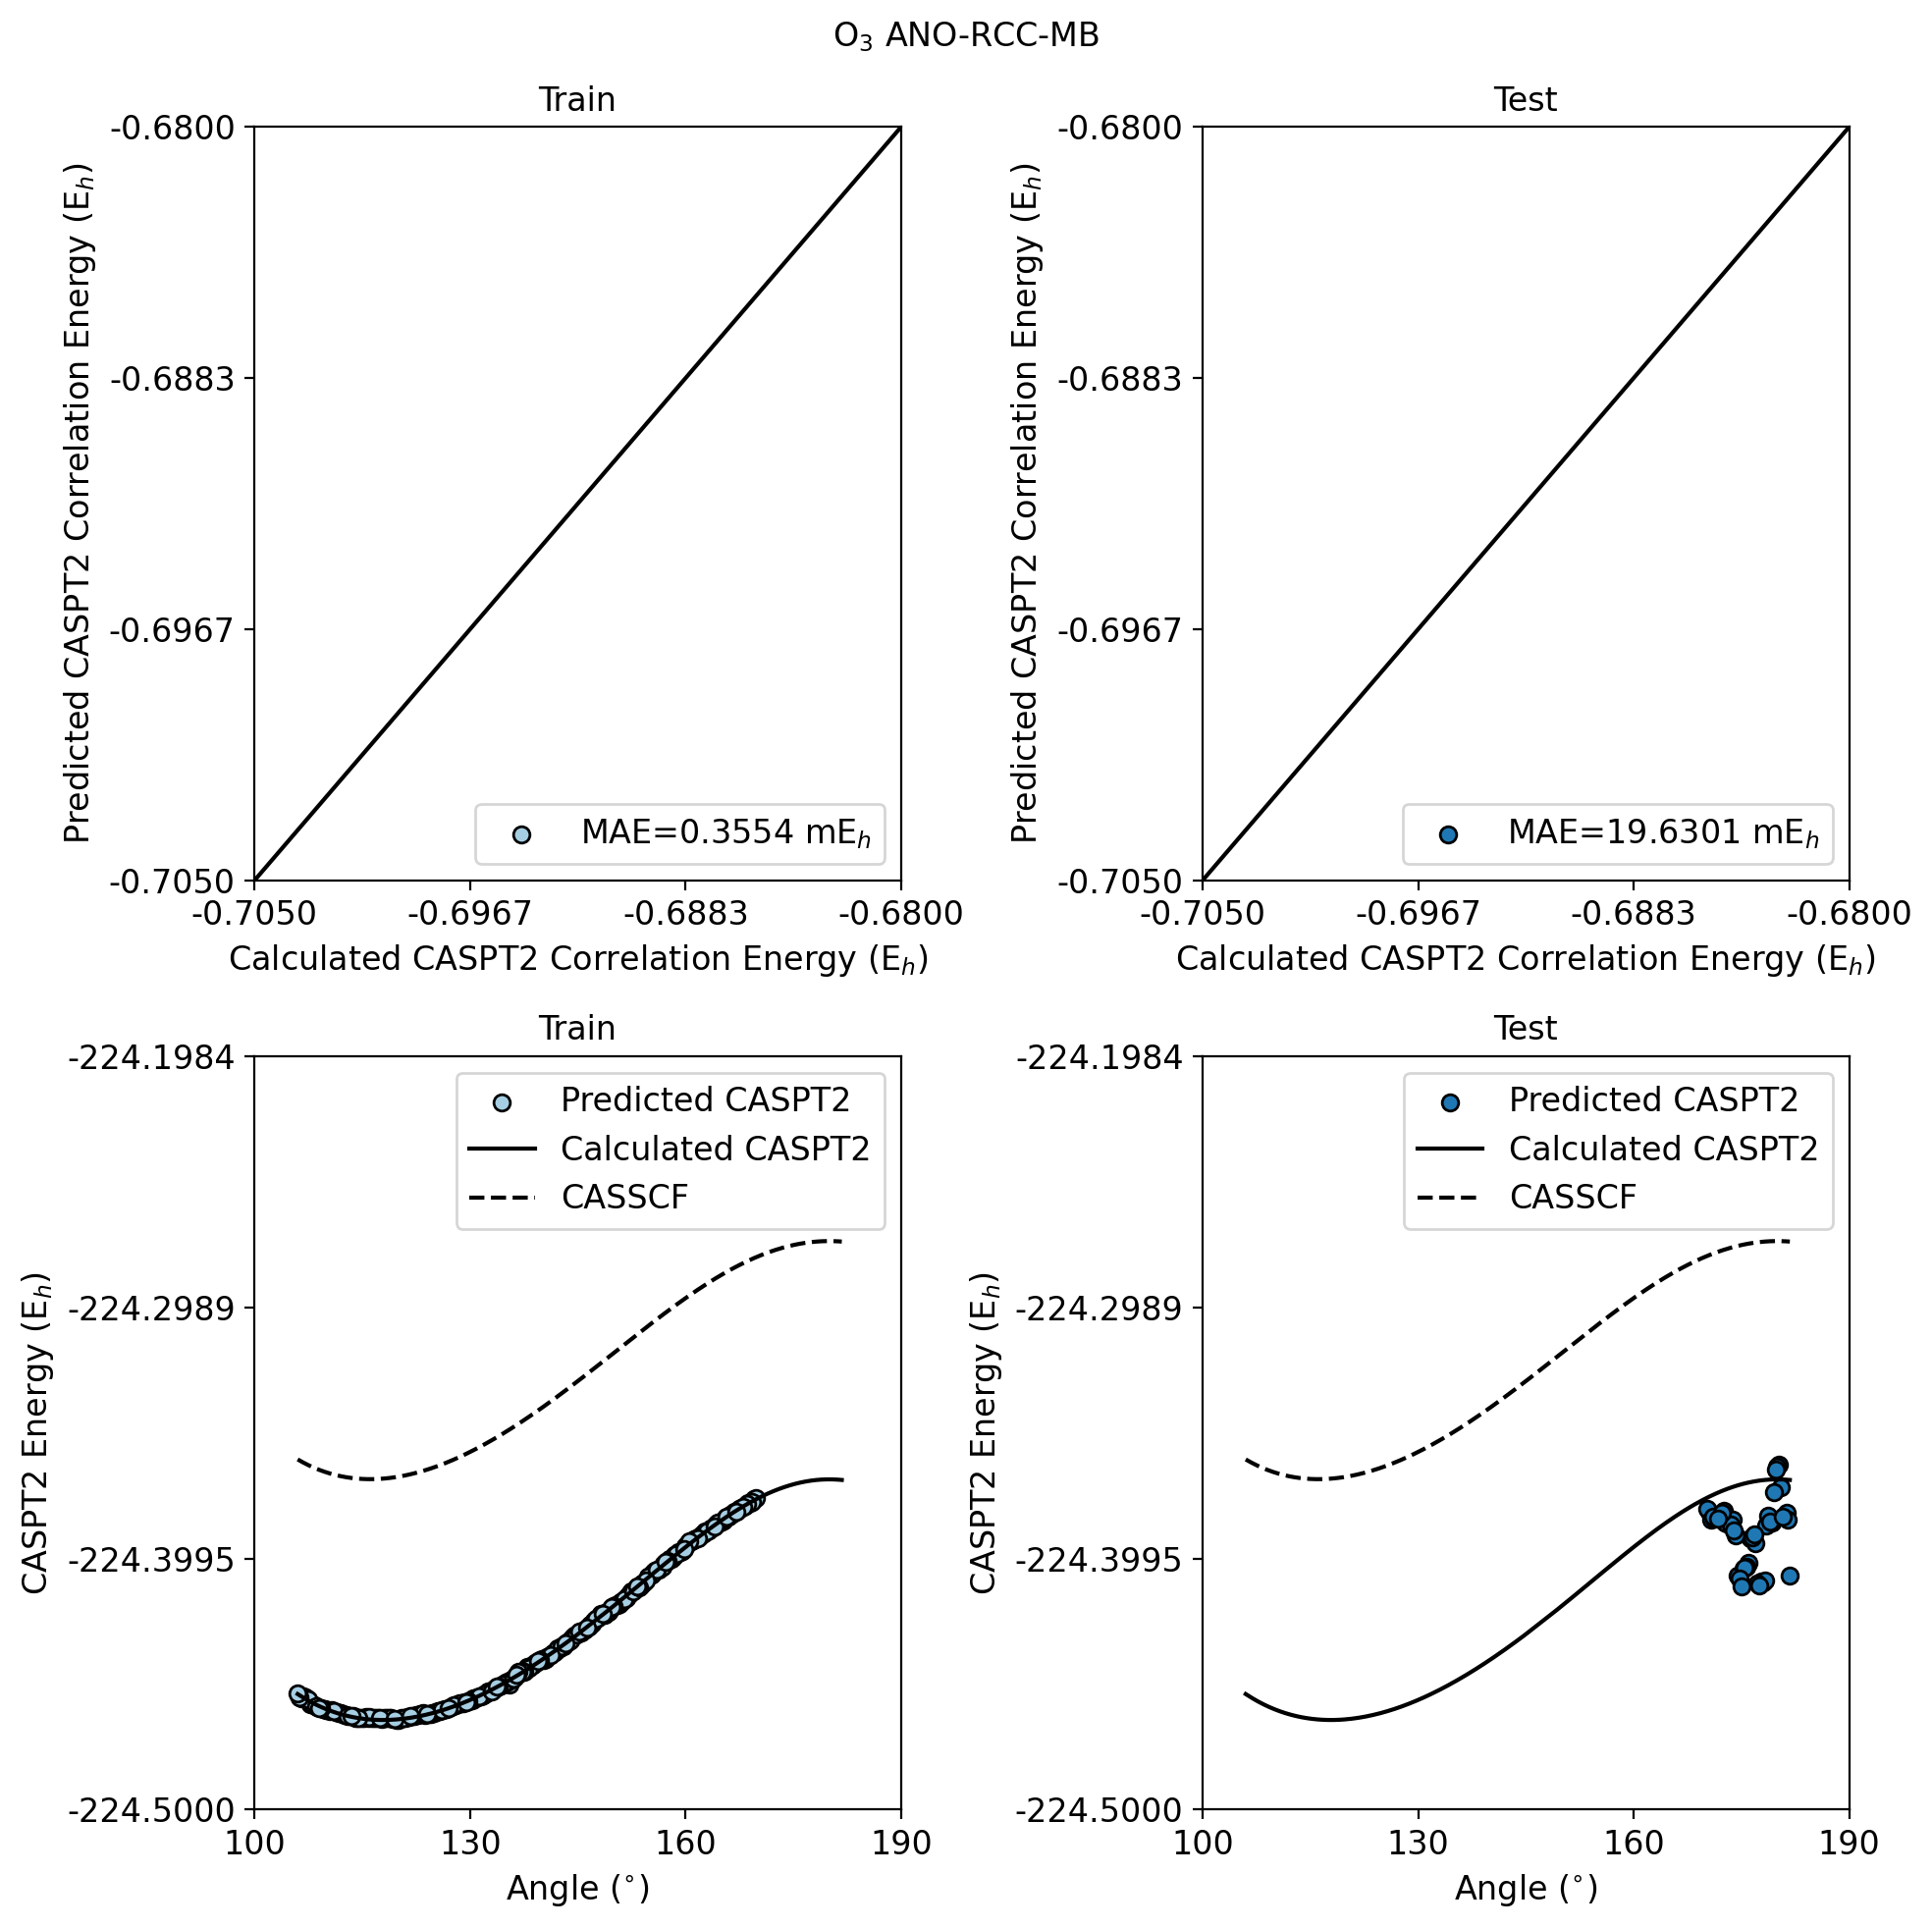

In [107]:
traincorrerr = {}

fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,10),sharey=False)



pred_train,true_train = traincorrE2['E$_{2}^{\text{Predicted}}$'],traincorrE2['E$_{2}^{\text{Calculated}}$']
pred_test,true_test = testcorrE2['E$_{2}^{\text{Predicted}}$'],testcorrE2['E$_{2}^{\text{Calculated}}$']
testrad = testcorrE2['Angle ($^{\circ}$)']    
train_r2_corr = r2_score(true_train,pred_train)
test_r2_corr = r2_score(true_test,pred_test)
test_mae_corr = 1e3*mean_absolute_error(true_test,pred_test)
train_mae_corr = 1e3*mean_absolute_error(true_train,pred_train)
print(train_r2_corr)
traincorrerr = {"r2_train":train_r2_corr,"r2_test":test_r2_corr,"mae_train":train_mae_corr,"mae_test":test_mae_corr}
trainrad = traincorrE2['Angle ($^{\circ}$)']
# ax1.scatter(true_train,pred_train,label='R$^{2}$='+f'{train_r2_corr:.4f}\nMAE={train_mae_corr:.4f}'+" mE$_{h}$",color=pairedcp[0],edgecolors='k')
ax1.scatter(true_train,pred_train,label=f'MAE={train_mae_corr:.4f}'+" mE$_{h}$",color=pairedcp[0],edgecolors='k')

ax1.set_xlabel('Calculated CASPT2 Correlation Energy (E$_{h}$)')
ax1.set_ylabel('Predicted CASPT2 Correlation Energy (E$_{h}$)')
ax1.set_title('Train')
ax1.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax1.legend(loc=4)


# ax2.scatter(true_test,pred_test,label='R$^{2}$='+f'{test_r2_corr:.4f}\nMAE={test_mae_corr:.4f}'+" mE$_{h}$",color=pairedcp[1],edgecolors='k')
ax2.scatter(true_test,pred_test,label=f'MAE={test_mae_corr:.4f}'+" mE$_{h}$",color=pairedcp[1],edgecolors='k')
# ax2.plot(true_test,true_test,'k')
ax2.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax2.set_xlabel('Calculated CASPT2 Correlation Energy (E$_{h}$)')
ax2.set_ylabel('Predicted CASPT2 Correlation Energy (E$_{h}$)')

ax2.set_title('Test')    
ax2.legend(loc=4)
# vdzp
# bottom, top = -0.1035,-0.091
# vdzp
# bottom, top = -0.545,-0.505
# MB 
bottom, top = -0.705,-0.68
ax1.set_xlim(bottom, top)
ax1.set_ylim(bottom, top)
ax2.set_xlim(bottom, top)
ax2.set_ylim(bottom, top)
ax1.set_xticks(np.linspace(bottom,top,4),[f"{i:.4f}" for i in np.linspace(bottom,top,4)])
ax1.set_yticks(np.linspace(bottom,top,4),[f"{i:.4f}" for i in np.linspace(bottom,top,4)])    
# ax2.set_xlim(bottom,top)
ax2.set_xticks(np.linspace(bottom,top,4),[f"{i:.4f}" for i in np.linspace(bottom,top,4)])    
# ax2.set_ylim(bottom,top)
ax2.set_yticks(np.linspace(bottom,top,4),[f"{i:.4f}" for i in np.linspace(bottom,top,4)])    

pred_train,true_train = traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'],traincorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$']
pred_test,true_test = testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'],testcorrE2['E$_{\text{CASPT2}}^{\text{Calculated}}$']
testrad = testcorrE2['Angle ($^{\circ}$)']    


traincorrerr = {"r2_train":train_r2_corr,"r2_test":test_r2_corr,"mae_train":train_mae_corr,"mae_test":test_mae_corr}
trainrad = traincorrE2['Angle ($^{\circ}$)']
ax3.scatter(np.array(trainrad,dtype=float),pred_train,color=pairedcp[0],edgecolors='k',label='Predicted CASPT2')
ax3.plot(allcorr.sort_values(by='Angle ($^{\circ}$)')['Angle ($^{\circ}$)'].astype(float),allcorr.sort_values(by='Angle ($^{\circ}$)')['E$_{\text{CASPT2}}^{\text{Calculated}}$'].astype(float),'k',label='Calculated CASPT2')
ax3.plot(allcorr.sort_values(by='Angle ($^{\circ}$)')['Angle ($^{\\circ}$)'].astype(float),allcorr.sort_values(by='Angle ($^{\circ}$)')['E$_{\text{CASSCF}}^{\text{Calculated}}$'].astype(float),'k--',label='CASSCF')
ax3.set_xlabel('Angle ($^{\circ}$)')
ax3.set_ylabel('CASPT2 Energy (E$_{h}$)')
ax3.set_title('Train')
ax3.legend()

ax4.scatter(np.array(testrad,dtype=float),pred_test,color=pairedcp[1],edgecolors='k',label='Predicted CASPT2')
ax4.plot(allcorr.sort_values(by='Angle ($^{\circ}$)')['Angle ($^{\circ}$)'].astype(float),allcorr.sort_values(by='Angle ($^{\circ}$)')['E$_{\text{CASPT2}}^{\text{Calculated}}$'].astype(float),'k',label='Calculated CASPT2')
ax4.plot(allcorr.sort_values(by='Angle ($^{\circ}$)')['Angle ($^{\\circ}$)'].astype(float),allcorr.sort_values(by='Angle ($^{\circ}$)')['E$_{\text{CASSCF}}^{\text{Calculated}}$'].astype(float),'k--',label='CASSCF')
ax4.set_xlabel('Angle ($^{\circ}$)')
ax4.set_ylabel('CASPT2 Energy (E$_{h}$)')
ax4.set_title('Test') 
ax4.legend()

minpt2, maxpt2= pd.concat([pred_train,true_train,pred_test,true_test]).min(), pd.concat([pred_train,true_train,pred_test,true_test]).max()
print(minpt2, maxpt2)
pct=0.004
bufferbot, buffertop = minpt2*pct, maxpt2*pct



#mb
bottom, top = -224.5, -224.1984 
#maxpt2-(buffertop) 

# vdzp: -224.40
# bottom, top = -225.2, -224.4

# MB
# bottom, top = -225.4, -224.4
print(bottom, top)
ax3.set_ylim(bottom,top)
ax3.set_xlim(100,190)
ax3.set_yticks(np.linspace(bottom,top,4),[f"{i:.4f}" for i in np.linspace(bottom,top,4)]) 
ax3.set_xticks(np.linspace(100,190,4),[f"{i:.0f}" for i in np.linspace(100,190,4)]) 
ax4.set_ylim(bottom,top)
ax4.set_xlim(100,190)
ax4.set_yticks(np.linspace(bottom,top,4),[f"{i:.4f}" for i in np.linspace(bottom,top,4)]) 
ax4.set_xticks(np.linspace(100,190,4),[f"{i:.0f}" for i in np.linspace(100,190,4)]) 


fig.suptitle("O$_{3}$ ANO-RCC-MB")

plt.subplots_adjust(wspace=0.05)
plt.tight_layout()
# plt.savefig(f'images/ozone_MBCASPT2.png',dpi=300,bbox_inches='tight')
plt.show()    

In [108]:
np.linspace(100,190,4)

array([100., 130., 160., 190.])

In [109]:
[f"{i:.4}" for i in np.linspace(bottom,top,4)]

['-224.5', '-224.4', '-224.3', '-224.2']

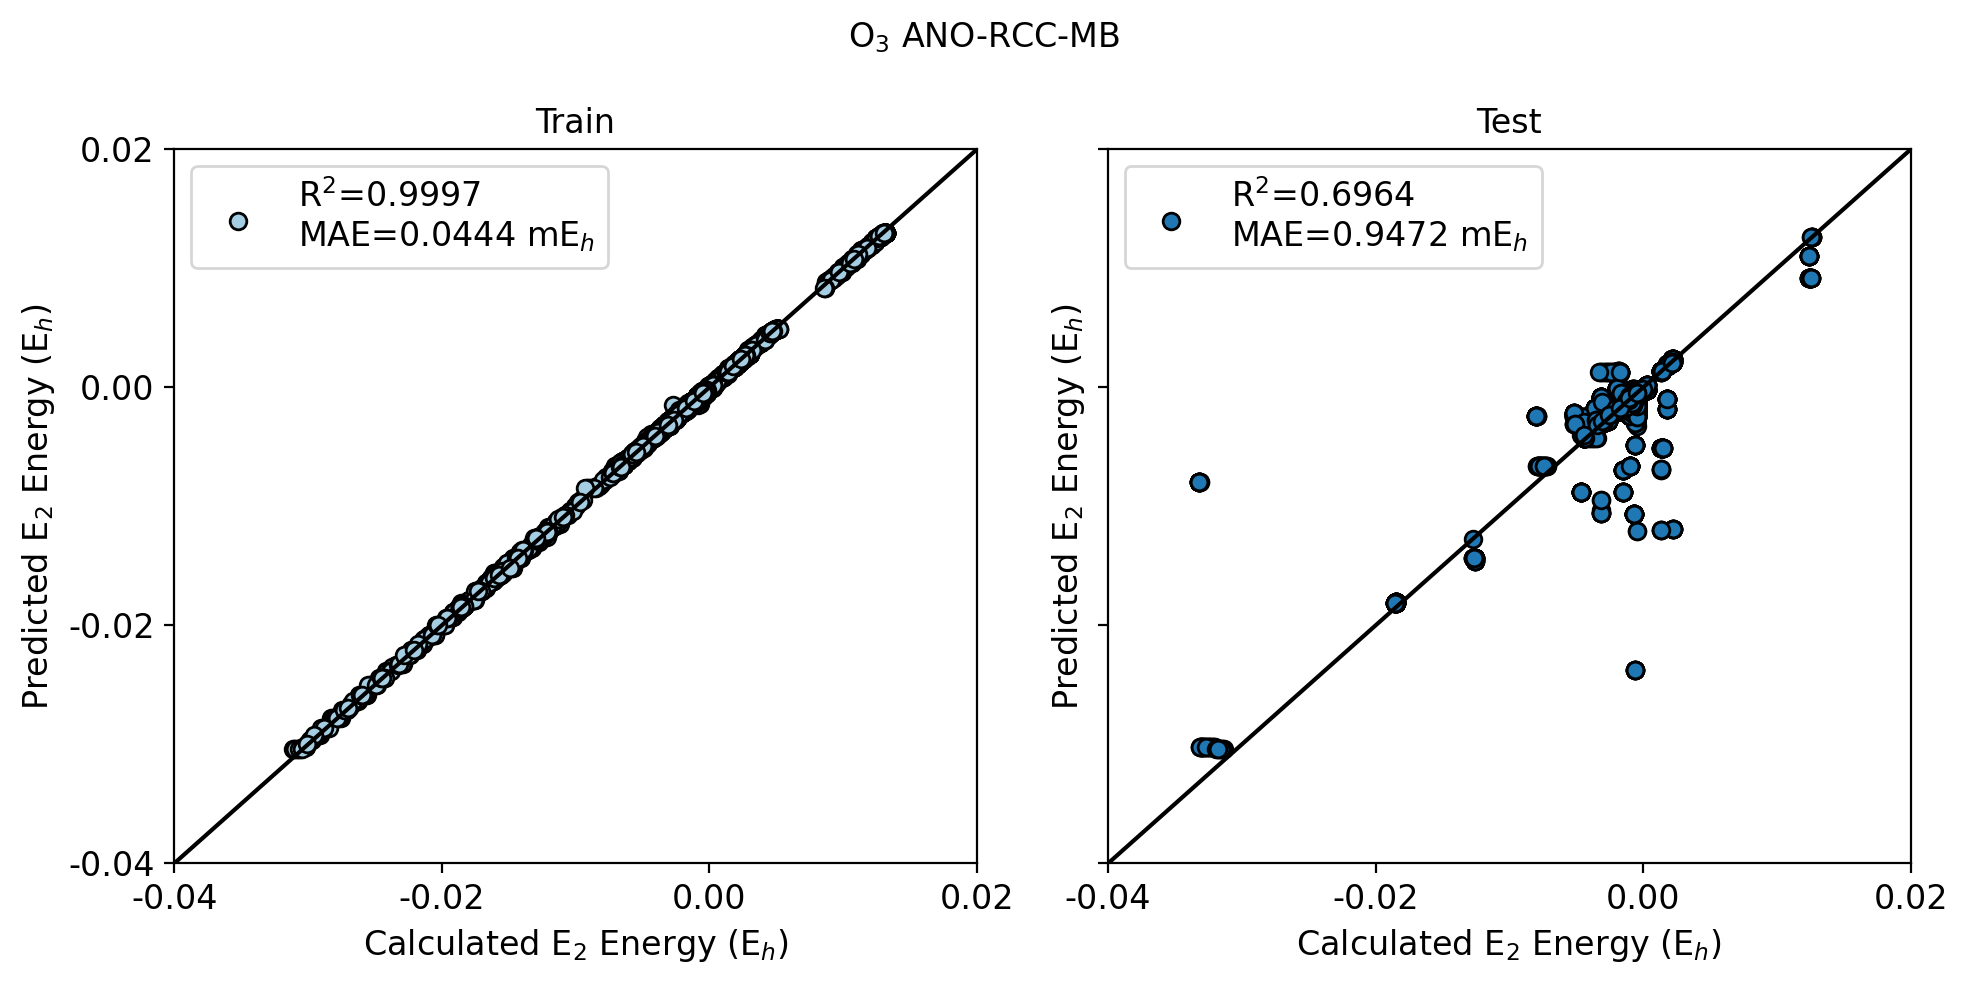

In [110]:
trainpairdf = pd.DataFrame(recover_train_list)
testpairdf = pd.DataFrame(recover_test_list)
pairerr={}

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)

truetrainpair, predtrainpair = np.hstack(trainpairdf[2]),np.hstack(trainpairdf[3])
train_r2_pair = r2_score(truetrainpair, predtrainpair)
train_mae_pair = 1e3*mean_absolute_error(truetrainpair, predtrainpair)
ax1.scatter(truetrainpair, predtrainpair,label='R$^{2}$='+f'{train_r2_pair:.4f}\nMAE={train_mae_pair:.4f}'+" mE$_{h}$",color=pairedcp[0],edgecolors='k')
ax1.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax1.set_xlabel('Calculated E$_2$ Energy (E$_{h}$)')
ax1.set_ylabel('Predicted E$_2$ Energy (E$_{h}$)')
ax1.set_title('Train')    
ax1.legend()  

truetestpair, predtestpair = np.hstack(testpairdf[2]),np.hstack(testpairdf[3])
test_r2_pair = r2_score(truetestpair, predtestpair)
test_mae_pair = 1e3*mean_absolute_error(truetestpair, predtestpair)
ax2.scatter(truetestpair, predtestpair,label='R$^{2}$='+f'{test_r2_pair:.4f}\nMAE={test_mae_pair:.4f}'+" mE$_{h}$",color=pairedcp[1],edgecolors='k')
ax2.plot(np.arange(-1000,1000),np.arange(-1000,1000),'k')
ax2.set_xlabel('Calculated E$_2$ Energy (E$_{h}$)')
ax2.set_ylabel('Predicted E$_2$ Energy (E$_{h}$)')
ax2.set_title('Test')    
ax2.legend()    

mincorr, maxcorr= np.hstack([truetrainpair,truetestpair]).min(), np.hstack([truetrainpair,truetestpair]).max()
pct=0.50
bufferbot, buffertop = mincorr*pct, maxcorr*pct

# if 'H' in n:
bottom, top = mincorr-buffertop, maxcorr+buffertop

# else:
#     bottom, top = mincorr+-0.1, maxcorr+0.05

ax1.set_xlim(bottom,top)
ax1.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])
ax1.set_ylim(bottom,top)
ax1.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
ax2.set_xlim(bottom,top)
ax2.set_xticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    
ax2.set_ylim(bottom,top)
ax2.set_yticks(np.linspace(bottom,top,4),[f"{i:.2f}" for i in np.linspace(bottom,top,4)])    

fig.suptitle("O$_{3}$ ANO-RCC-MB")
plt.tight_layout()
# plt.savefig(f'images/ozone_MBE2.png',dpi=300,bbox_inches='tight')    
plt.show()
pairerr = {"r2_train":train_r2_pair,"r2_test":test_r2_pair,"mae_train":train_mae_pair,"mae_test":test_mae_pair}

In [ ]:
pd.DataFrame(np.vstack([testpairdf[1].astype(float),[mean_absolute_error(u,v) for u,v in np.vstack([testpairdf[2],testpairdf[3]]).T]])).T.sort_values(by=0).iloc[13]

In [ ]:
np.argmax([mean_absolute_error(u,v) for u,v in zip(testpairdf[2],testpairdf[3])])

In [ ]:
trainpairmae = np.array([mean_absolute_error(u,v) for u,v in np.vstack([trainpairdf[2],trainpairdf[3]]).T])
testpairmae = np.array([mean_absolute_error(u,v) for u,v in np.vstack([testpairdf[2],testpairdf[3]]).T])

In [ ]:
np.argsort(trainpairmae)[-5:],np.round(1e3*trainpairmae[np.argsort(trainpairmae)[-10:]],4)

In [ ]:
cleanedtrain = traincorrE2.drop(index=traincorrE2.iloc[np.argsort(trainpairmae)[-10:]].index)

In [ ]:
traincorrE2.iloc[np.argsort(trainpairmae)[-10:]]

In [ ]:
np.round(1e3*mean_absolute_error(cleanedtrain['E$_{2}^{\text{Calculated}}$'],cleanedtrain['E$_{2}^{\text{Predicted}}$']),4)

In [ ]:
np.round(r2_score(cleanedtrain['E$_{2}^{\text{Calculated}}$'],cleanedtrain['E$_{2}^{\text{Predicted}}$']),4)

In [ ]:
plt.bar(*np.vstack([trainpairdf[1].astype(float),[mean_absolute_error(u,v) for u,v in np.vstack([trainpairdf[2],trainpairdf[3]]).T]]))

In [ ]:
plt.bar(*np.vstack([testpairdf[1].astype(float),[mean_absolute_error(u,v) for u,v in np.vstack([testpairdf[2],testpairdf[3]]).T]]))

In [ ]:
plt.bar(*np.vstack([trainpairdf[1].astype(float),[mean_absolute_error(u,v) for u,v in np.vstack([trainpairdf[2],trainpairdf[3]]).T]]))